In [1]:
import csv

# Load in the pre-processed Facebook chat file with ~ 6300 actual messages, 5800 of which are longer than 5 characters
with open('fchat.csv', 'rb') as csvfile:
    messages = [' '.join(row) for row in csv.reader(csvfile)]
    
# Split messages into sessions by the respective messager
message_owner = ""
A = []
M = []

# Data is row by row with markers indicating new sessions or messager
for message in messages:
    if message == "NewSessionMarker":
            # Create a new session in the list with no text
            A.append('')
            M.append('')
    elif message == "AndyStartMarker":
        message_owner = "A"
    elif message == "MinaeStartMarker":
        message_owner = "M" 
    else:
        # Append text session-wise to the current messager
        if message_owner == "A":
            A[len(A)-1] = A[len(A)-1] + '. ' + message
        elif message_owner == "M":
            M[len(M)-1] = M[len(M)-1] + '. ' +  message   

In [2]:
import re
import unicodedata

# Perform some basic data cleaning
def clean_message_list(message_list):
    for k in range(0, len(message_list)):
        # Set all text to lower
        clean = message_list[k].lower()
        
        # Replace ~, slashes, dashes, hyphens and colons with space
        # Note that emoticons have already been pre-processed
        clean = re.sub('[/\\-—`:]', ' ', clean)
        
        # Remove unicode
        clean = clean.decode('unicode_escape').encode('ascii','ignore')
        
        # Strip
        clean = clean.strip()
        
        # Replace with clean text
        message_list[k] = clean

# Inspect the data before and after
# print "Original format:"
# print ""
# print A[0:5]
# print "----------"
# print M[0:5]
# print ""

clean_message_list(A)
clean_message_list(M)

# print "Clean format:"
# print ""
# print A[0:5]
# print "----------"
# print M[0:5]
# print ""

In [3]:
import nltk

# Useless strings generated by nltk tokenizer for contractions
remove =  (["''", "#", "``", "'d", "'ll", "'m", "n't", "'re", "'s", "'ve"])

# Custom sentence-wise tokenizer for word2vec input
# word2vec takes in a list of sentences broken into tokens
def sentence_tokenize(doc):       
        # Split into sentences based on nltk definition of a sentence
        sentences = nltk.sent_tokenize(doc) 
        
        # Generate a list of tokens for each sentence
        sentence_token_list = []
        for sentence in sentences:
            # Ignore sentences that are only a single character
            if len(sentence) > 1:              
                sentence_token_list.append(
                    [
                        word
                        for word in nltk.word_tokenize(sentence)
                        # At least one alpha character is required for "words"
                        if word not in remove and len(re.sub('[^a-zA-Z]', '', word)) > 0
                    ])       
                
        return sentence_token_list

# Create the list of sentences (by session) and tokenize each sentence
sentences_A = []
for session in A:
    sentences_A.append(sentence_tokenize(session))    
    
sentences_M = []
for session in M:
    sentences_M.append(sentence_tokenize(session))    
    
# Inspect for correctness
# for session in sentences_A[0:5]:
#     for sentence in session:
#         print sentence

# print "----------"

# for session in sentences_M[0:5]:
#     for sentence in session:
#         print sentence

In [4]:
# Flatten all sessions into a large list of sentences broken into tokens
# Ignore sentences with 2 tokens or less, since they will not reveal context about a word and inflate count
# Later session-wise filtering can be used to reveal changes in chat behavior

all_sentences_A = []
for session in sentences_A:
    for sentence in session:
        if len(sentence) > 2:
            all_sentences_A.append(sentence)

all_sentences_M = []
for session in sentences_M:
    for sentence in session:
        if len(sentence) > 2:
            all_sentences_M.append(sentence)

#Inspect for correctness
# print all_sentences_A[0:10]
# print "----------"
# print all_sentences_M[0:10]

In [5]:
### standard word2vec parameters for all models to keep things generalized ###

# A minimum word occurence of 5 should remove somes dirty data
#
# 64 cores available
#
# The default skip-gram window of 5 is used (4 may be appropriate due to the shortness of sentences)
#
# Due to the small size of the data, multiple iterations are easy to compute to improve accuracy
#
# The size of a model is often thought of as the number of topics
# Some recommend using a size of sqrt(length of vocabulary), although I use slightly more due to the noisiness of the data

min_count = 5
workers = 64
window = 4
iter = 500
size = 30

from random import shuffle
# Shuffle order of sentences
shuffle(all_sentences_A)
shuffle(all_sentences_M)

In [6]:
from gensim.models import Word2Vec

# Skip-gram Word2Vec
model_A = Word2Vec(all_sentences_A, 
                   min_count = min_count, 
                   workers = workers, 
                   window = window, 
                   iter = iter, 
                   size = size)

In [7]:
# Test words with expected similarities
test = ['school', 'work', 'love']

for word in test:
    print "Similar to: " + word
    for match in model_A.most_similar(word)[0:10]:
        print match[0]
    print "--------------"
    
print ""

Similar to: school
research
dad
etc..
frownemoticon
based
mind
schedule
serious
eh
snap
--------------
Similar to: work
their
subconscious
school
pick
schedule
grow
always
his
stats
reception
--------------
Similar to: love
miss
heartemoticon
sending
minnie
hope
happy
oyasumi
thank
memories
dear
--------------



In [8]:
# Procedures to return the top words in a corpus based on count and co-occurence

def _get_param_matrices(vocabulary, sentence_terms):
    """
    Returns
    1. Top 300 (or less, if vocab is short) most frequent terms as a list
    2. Co-occurence matrix for these terms as a dictionary
    3. Dictionary containing Pg (expected probability) of most-frequent terms
    4. Number of terms affected of each term as a dictionary
    """
 
    #Figure out top n terms with respect to mere occurences
    n = min(300, len(vocabulary))
    topterms = list(vocabulary.keys())
    topterms.sort(key = lambda x: vocabulary[x], reverse = True)
    topterms = topterms[:n]
 
    #nw maps term to the number of terms it 'affects'
    #(sum of number of terms in all sentences it
    #appears in)
    nw = {}
    #Co-occurence values are wrt top terms only
    co_occur = {}
    #Initially, co-occurence matrix is empty
    for x in vocabulary:
        co_occur[x] = [0 for i in range(len(topterms))]
 
    #Iterate over list of all sentences' vocabulary dictionaries
    #Build the co-occurence matrix
    for sentence in sentence_terms:
        total_terms = sum(list(sentence.values()))
        #This list contains the indices of all terms from topterms,
        #that are present in this sentence
        top_indices = []
        #Populate top_indices
        top_indices = [topterms.index(x) for x in sentence
                       if x in topterms]
        #Update nw dict, and co-occurence matrix
        for term in sentence:
            nw[term] = nw.get(term, 0) + total_terms
            for index in top_indices:
                co_occur[term][index] += (sentence[term] *
                                          sentence[topterms[index]])
 
    #Pg is just nw[term]/total vocabulary of text
    Pg = {}
    N = sum(list(vocabulary.values()))
    for x in topterms:
        Pg[x] = float(nw[x])/N
 
    return topterms, co_occur, Pg, nw

def get_top_n_terms(vocabulary, sentence_terms, n):
    """
    Returns the top 'n' terms from a block of text, in the form of a list,
    from most important to least.
 
    'vocabulary' should be a dict mapping each term to the number
    of its occurences in the entire text.
    'sentence_terms' should be an iterable of dicts, each denoting the
    vocabulary of the corresponding sentence.
    """
 
    #First compute the matrices
    topterms, co_occur, Pg, nw = _get_param_matrices(vocabulary,
                                                     sentence_terms)
 
    #This dict will map each term to its weightage with respect to the
    #document
    result = {}
 
    N = sum(list(vocabulary.values()))
    #Iterates over all terms in vocabulary
    for term in co_occur:
        term = str(term)
        org_term = str(term)
        for x in Pg:
            #expected_cooccur is the expected cooccurence of term with this
            #term, based on nw value of this and Pg value of the other
            expected_cooccur = nw[term] * Pg[x]
            #Result measures the difference(in no of terms) of expected
            #cooccurence and  actual cooccurence
            result[org_term] = ((co_occur[term][topterms.index(x)] -
                                 expected_cooccur)**2/ float(expected_cooccur))
 
    terms = list(result.keys())
    terms.sort(key=lambda x: result[x],
               reverse=True)
 
    return terms[:n]

In [60]:
from nltk.corpus import stopwords
stop_list = stopwords.words('english')

from collections import Counter

vocab_A = list(model_A.vocab.keys())
print str(len(vocab_A)) + " words in the vocabulary"
print ""

# Create a corpus of all tokens to count all words occurences
full_word_A= []
for sentence in all_sentences_A:
    full_word_A.extend(sentence)

full_vocab_count_A = Counter(full_word_A)

# Create a sentence-wise count of tokens to pass into the top_n_terms function
# This is used to calculate co-occurence of words
sentence_vocab_count_list_A = []
for sentence in all_sentences_A:
    sentence_vocab_count_list_A.append(Counter(sentence)) 

# Find the top 200 words, which will be pruned later
top_terms_A = get_top_n_terms(full_vocab_count_A, sentence_vocab_count_list_A, n = 250)

# A manually identified set of common words with ambigious usage (like 'pretty' in 'pretty bad/good')
# It helped being the actual person who wrote and read the messages recently!
# Note that some of these words were never found, but are related to ambigious words that were found

common_words = [
    "able",
    "actually",
    "add",
    "agree",
    "agreed",
    "alright",
    "also",
    "although",
    "another",
    "anything",
    "around",
    "back",
    "based",
    "because",
    "bit",
    "can",
    "cant",
    "chance",
    "check",
    "could",
    "course",
    "cuz",
    "days",
    "def",
    "definitely",
    "defnitely",
    "defs",
    "difference",
    "dosnt",
    "due",
    "enough",
    "especially",
    "even",
    "example",
    "facebook",
    "fact",
    "far",
    "find",
    "first",
    "get",
    "getting",
    "go",
    "going",
    "got",
    "gunna",
    "guy",
    "guys",
    "hi",
    "holdup",
    "how",
    "im",
    "instance",
    "instead",
    "kind",
    "kinda",
    "kk",
    "kno",
    "know",
    "left",
    "let",
    "like",
    "literally",
    "long",
    "look",
    "lot",
    "made",
    "make",
    "makes",
    "making",
    "many",
    "may",
    "maybe",
    "mean",
    "means",
    "might",
    "much",
    "na",
    "nah",
    "naw",
    "never",
    "new",
    "no",
    "nope",
    "ofcourse",
    "ok",
    "okay",
    "one",
    "other",
    "our",
    "people",
    "person",
    "phone",
    "photo",
    "pic",
    "pretty",
    "profile",
    "rather",
    "read",
    "really",
    "right",
    "said",
    "saw",
    "say",
    "sec",
    "second",
    "see",
    "send",
    "sense",
    "share",
    "short",
    "since",
    "snap",
    "so",
    "someone",
    "something",
    "still",
    "stuff",
    "sure",
    "take",
    "tell",
    "thing",
    "things",
    "think",
    "though",
    "thought",
    "till",
    "told",
    "two",
    "until",
    "up",
    "ur",
    "us",
    "use",
    "used",
    "view",
    "waht",
    "wan",
    "wanna",
    "wanted",
    "way",
    "well",
    "went",
    "what",
    "when",
    "where",
    "who",
    "why",
    "wo",
    "wont",
    "word",
    "would",
    "yeah",
    "yes",
    "yo",
    "true",
    "sent",
    "msg",
    "point",
    "water",
    "words",
    "link",
    "keep",
    "put",
    "message",
    "friends",
    "shit",
    "dads",
    "kids"
]
    
stop_list.extend(common_words)
# Remove any duplicates
stop_list = list(set(stop_list))

# Some most frequent words will not be found in the vocabulary of the model due to data limitations
# Remove stop words and the manually identified common words
top_terms_A = [word for word in top_terms_A if (word in vocab_A and word not in stop_list)]

print str(len(top_terms_A) )+ " top words found"

660 words in the vocabulary

72 top words found


In [25]:
from scipy.spatial.distance import cosine
from networkx import Graph

# Procedures to generate a mind map

# Apply special formatting to a node name
def formatNode(node):
    
    # Custom mapping for emoticons and other symbols
    special_symbol_map = {'grinemoticon' : ':D',    
    'bigsmileemoticon': ':D ',
    'heartemoticon': '<3',
    'heartemoticonmultiple': '<3<3<3',
    'smileemoticon': ':)',
    'frownemoticon': ':( ',
    'unsureemoticon': ':/ ',
    'dotdotdot': '...',
    'doubledot': '..',
    'winkemoticon': ';)',
    'tongueemoticon': ':P',
    'unimpressedface': '-_-',
    'colonthreeemoticon': ':3',
    'gaspemoticon': ':O',
    'likeemoticon': 'ThumbsUp',
    'lolcaps': 'LOL'
    }
    
    if node in special_symbol_map:
        return special_symbol_map[node]
    else:
        return node.capitalize()

# Procedure to build mindmap based on a shortest path algorithm
# https://codesachin.wordpress.com/2015/10/15/generating-rudimentary-mind-maps-from-word2vec-models/
def build_mind_map(model, root, nodes, alpha):
    """
    Returns the Mind-Map in the form of a NetworkX Graph instance.
 
    'model' should be an instance of gensim.models.Word2Vec
    'nodes' should be a list of terms, included in the vocabulary of
    'model'.
    'root' should be the node that is to be used as the root of the Mind
    Map graph.
    """
 
    #This will be the Mind-Map
    g = Graph()
 
    #Ensure that the every node is in the vocabulary of the Word2Vec
    #model, and that the root itself is included in the given nodes
    for node in nodes:
        if node not in model.vocab:
            raise ValueError(node + " not in model's vocabulary")
    if root not in nodes:
        raise ValueError("root not in nodes")
 
    ##Containers for algorithm run
    #Initially, all nodes are unvisited
    unvisited_nodes = set(nodes)
    #Initially, no nodes are visited
    visited_nodes = set([])
    #The following will map visited node to its contextual vector
    visited_node_vectors = {}
    #Thw following will map unvisited nodes to (closest_distance, parent)
    #parent will obviously be a visited node
    node_distances = {}
 
    #Initialization with respect to root
    current_node = root
    visited_node_vectors[root] = model[root]
    unvisited_nodes.remove(root)
    visited_nodes.add(root)
 
    #Build the Mind-Map in n-1 iterations
    for i in range(1, len(nodes)):
        #For every unvisited node 'x'
        for x in unvisited_nodes:
            #Compute contextual distance between current node and x
            dist_from_current = cosine(visited_node_vectors[current_node],
                                       model[x])
            #Get the least contextual distance to x found until now
            distance = node_distances.get(x, (100, ''))
            #If current node provides a shorter path to x, update x's
            #distance and parent information
            if distance[0] > dist_from_current:
                node_distances[x] = (dist_from_current, current_node)
 
        #Choose next 'current' as that unvisited node, which has the
        #lowest contextual distance from any of the visited nodes
        next_node = min(unvisited_nodes,
                        key=lambda x: node_distances[x][0])
 
        ##Update all containers
        parent = node_distances[next_node][1]
        del node_distances[next_node]
        next_node_vect = ((1 - alpha)*model[next_node] +
                          alpha*visited_node_vectors[parent])
        visited_node_vectors[next_node] = next_node_vect
        unvisited_nodes.remove(next_node)
        visited_nodes.add(next_node)
 
        #Add the link between newly selected node and its parent(from the
        #visited nodes) to the NetworkX Graph instance
        g.add_edge(formatNode(parent), formatNode(next_node))
 
        #The new node becomes the current node for the next iteration
        current_node = next_node
 
    return g

In [44]:
#  Alpha is used to mix a node with its parent
# Using a larger alpha creates hybridized word-contexts with higher weighting towards the parent
# This generally causing long chains of words, which is less desirable for this exercise
# A higher alpha is useful when a word is sometimes used in a desired a specific context, but also in ambigious ones
# More info at https://codesachin.wordpress.com/2015/10/15/generating-rudimentary-mind-maps-from-word2vec-models/

G_A  = build_mind_map(model = model_A,  root = top_terms_A[0], nodes = top_terms_A, alpha=0.2)

In [179]:
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Used to visualize the models
def plot(G):
    # Find a spring layout for the node positions
    # Set iterations much higher than 50 due to the difficulty of fitting all words
    pos = nx.spring_layout(G, iterations= 250)

    # Find the centrallness of a node based on average distance
    centralness = nx.closeness_centrality(G)
    # Find the maximum and minimum centrallness to aid in coloring
    max_centrality = max(centralness.itervalues())
    min_centrality = min(centralness.itervalues())

    # Create a normalized color map space with the respective min and max centrality
    # Add some slack so central and ending nodes are not so extreme on the color map
    # Ends typically are more sensitive to this, thus the extra reduction
    norm = mpl.colors.Normalize(vmin= min_centrality*0.8, vmax = max_centrality*1.1)
    # Use a color map from cm
    cmap = cm.gnuplot2
    # Declare the map m
    m = cm.ScalarMappable(norm=norm, cmap=cmap)

    ## Construct a list of colors then pass to node_color
    color_list = [m.to_rgba(centralness[node]) for node in G]

    # Draw the nodes and labels
    # Tinkering with the node and font size yielded the below result
    nx.draw_networkx_nodes(G,pos=pos, node_color = color_list, node_size = 10000, alpha = 0.2)
    nx.draw_networkx_labels(G,pos=pos, fontsize=12)

    # Increase size of plot to reduce overlap of text
    N = 8.5
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*N, plSize[1]*N) )

    # Turn off axis ticks and labels
    plt.tick_params(
        axis = 'both',    which = 'both',    
        top='off',    right='off',    bottom='off',    left='off',    
        labelbottom='off',    labelleft='off',    labeltop='off',    labelright='off'
        )

    # Find maximum and minimum x/y values based on spring layout
    min_y = 0
    max_y = 0
    min_x = 0
    max_x = 0

    for key, value in pos.iteritems():
        if max_x < value[0]:
            max_x = value[0]
        elif min_x > value[0]:
            min_x = value[0]

        if max_y < value[1]:
            max_y = value[1]
        elif min_y > value[1]:
            min_y = value[1]

    # Extend limits by 10%
    extend_axis = 1.1
    plt.xlim([extend_axis*min_x, extend_axis*max_x])
    plt.ylim([extend_axis*min_y, extend_axis*max_y])

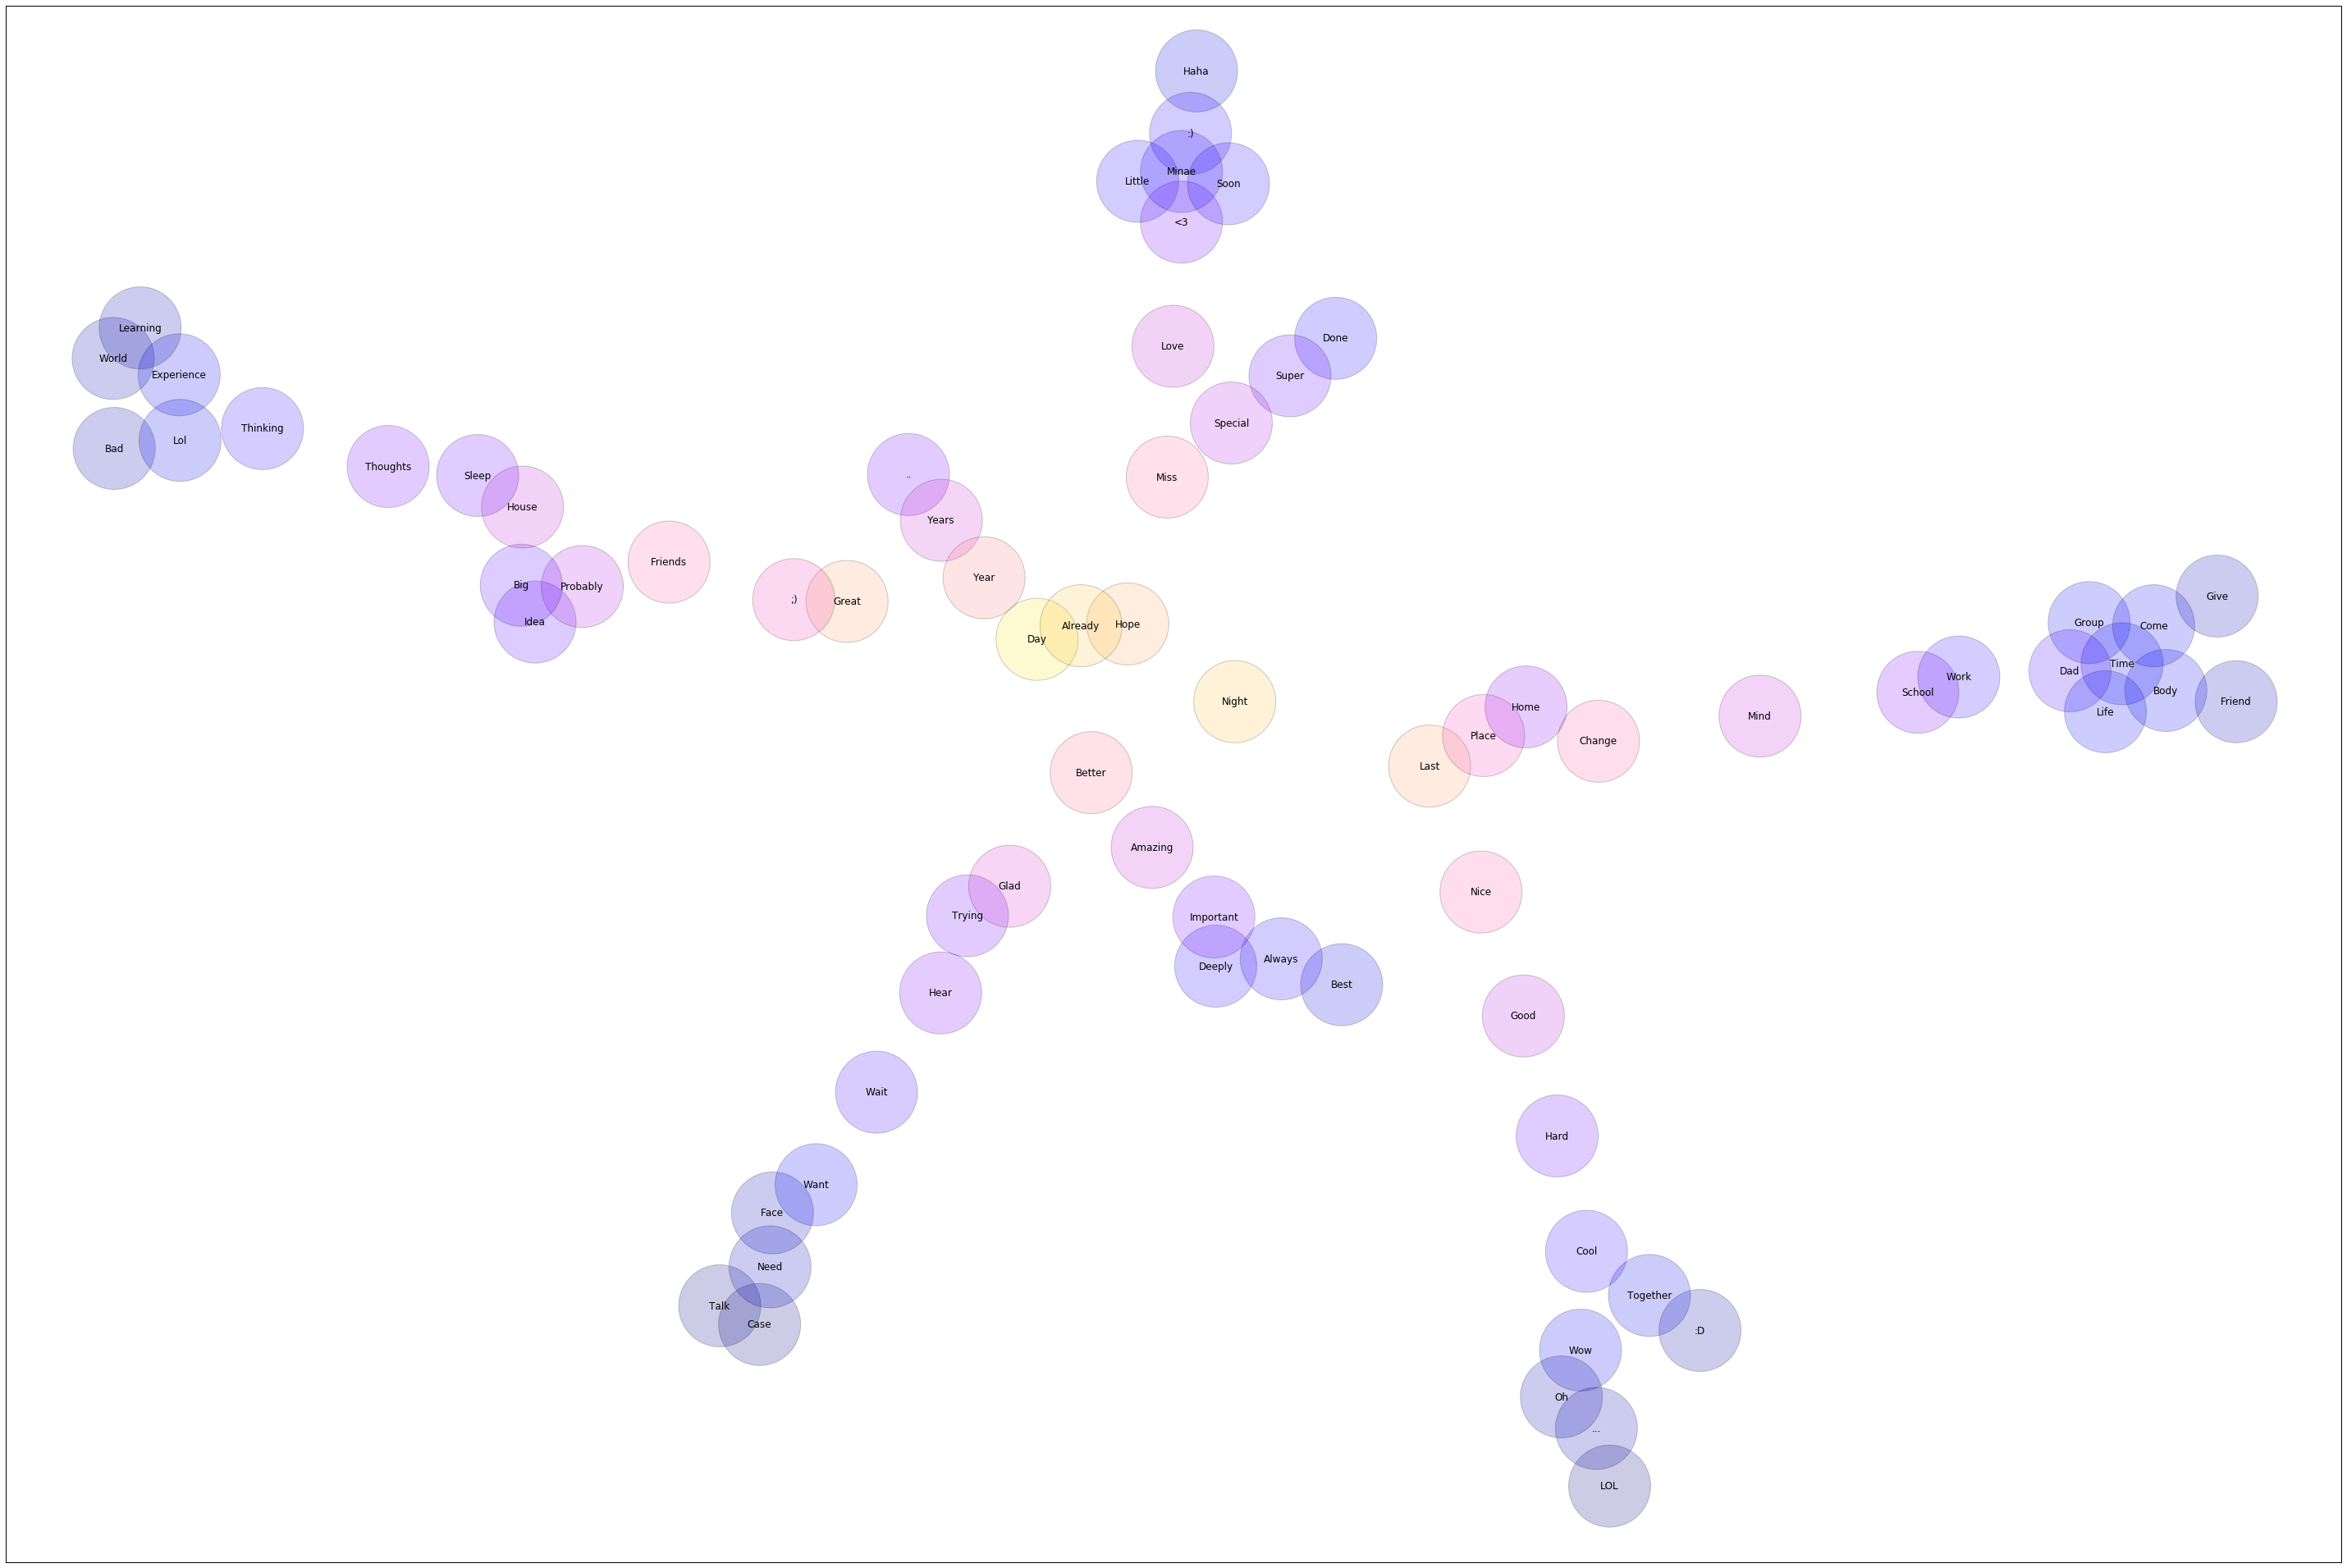

In [51]:
plot(G_A)

In [14]:
# Repeat the process for the other messager

model_M = Word2Vec(all_sentences_M, 
                   min_count = min_count, 
                   workers = workers, 
                   window = window, 
                   iter = iter, 
                   size = size)

In [61]:
vocab_M = list(model_M.vocab.keys())
print str(len(vocab_M)) + " words in the vocabulary"
print ""

# Find counts
full_word_M= []
for sentence in all_sentences_M:
    full_word_M.extend(sentence)
    
full_vocab_count_M= Counter(full_word_M)

sentence_vocab_count_list_M = []
for sentence in all_sentences_M:
    sentence_vocab_count_list_M.append(Counter(sentence)) 

# Determine top terms
top_terms_M = get_top_n_terms(full_vocab_count_M, sentence_vocab_count_list_M, n = 250)
top_terms_M = [word for word in top_terms_M if word in vocab_M and word not in stop_list]

727 words in the vocabulary



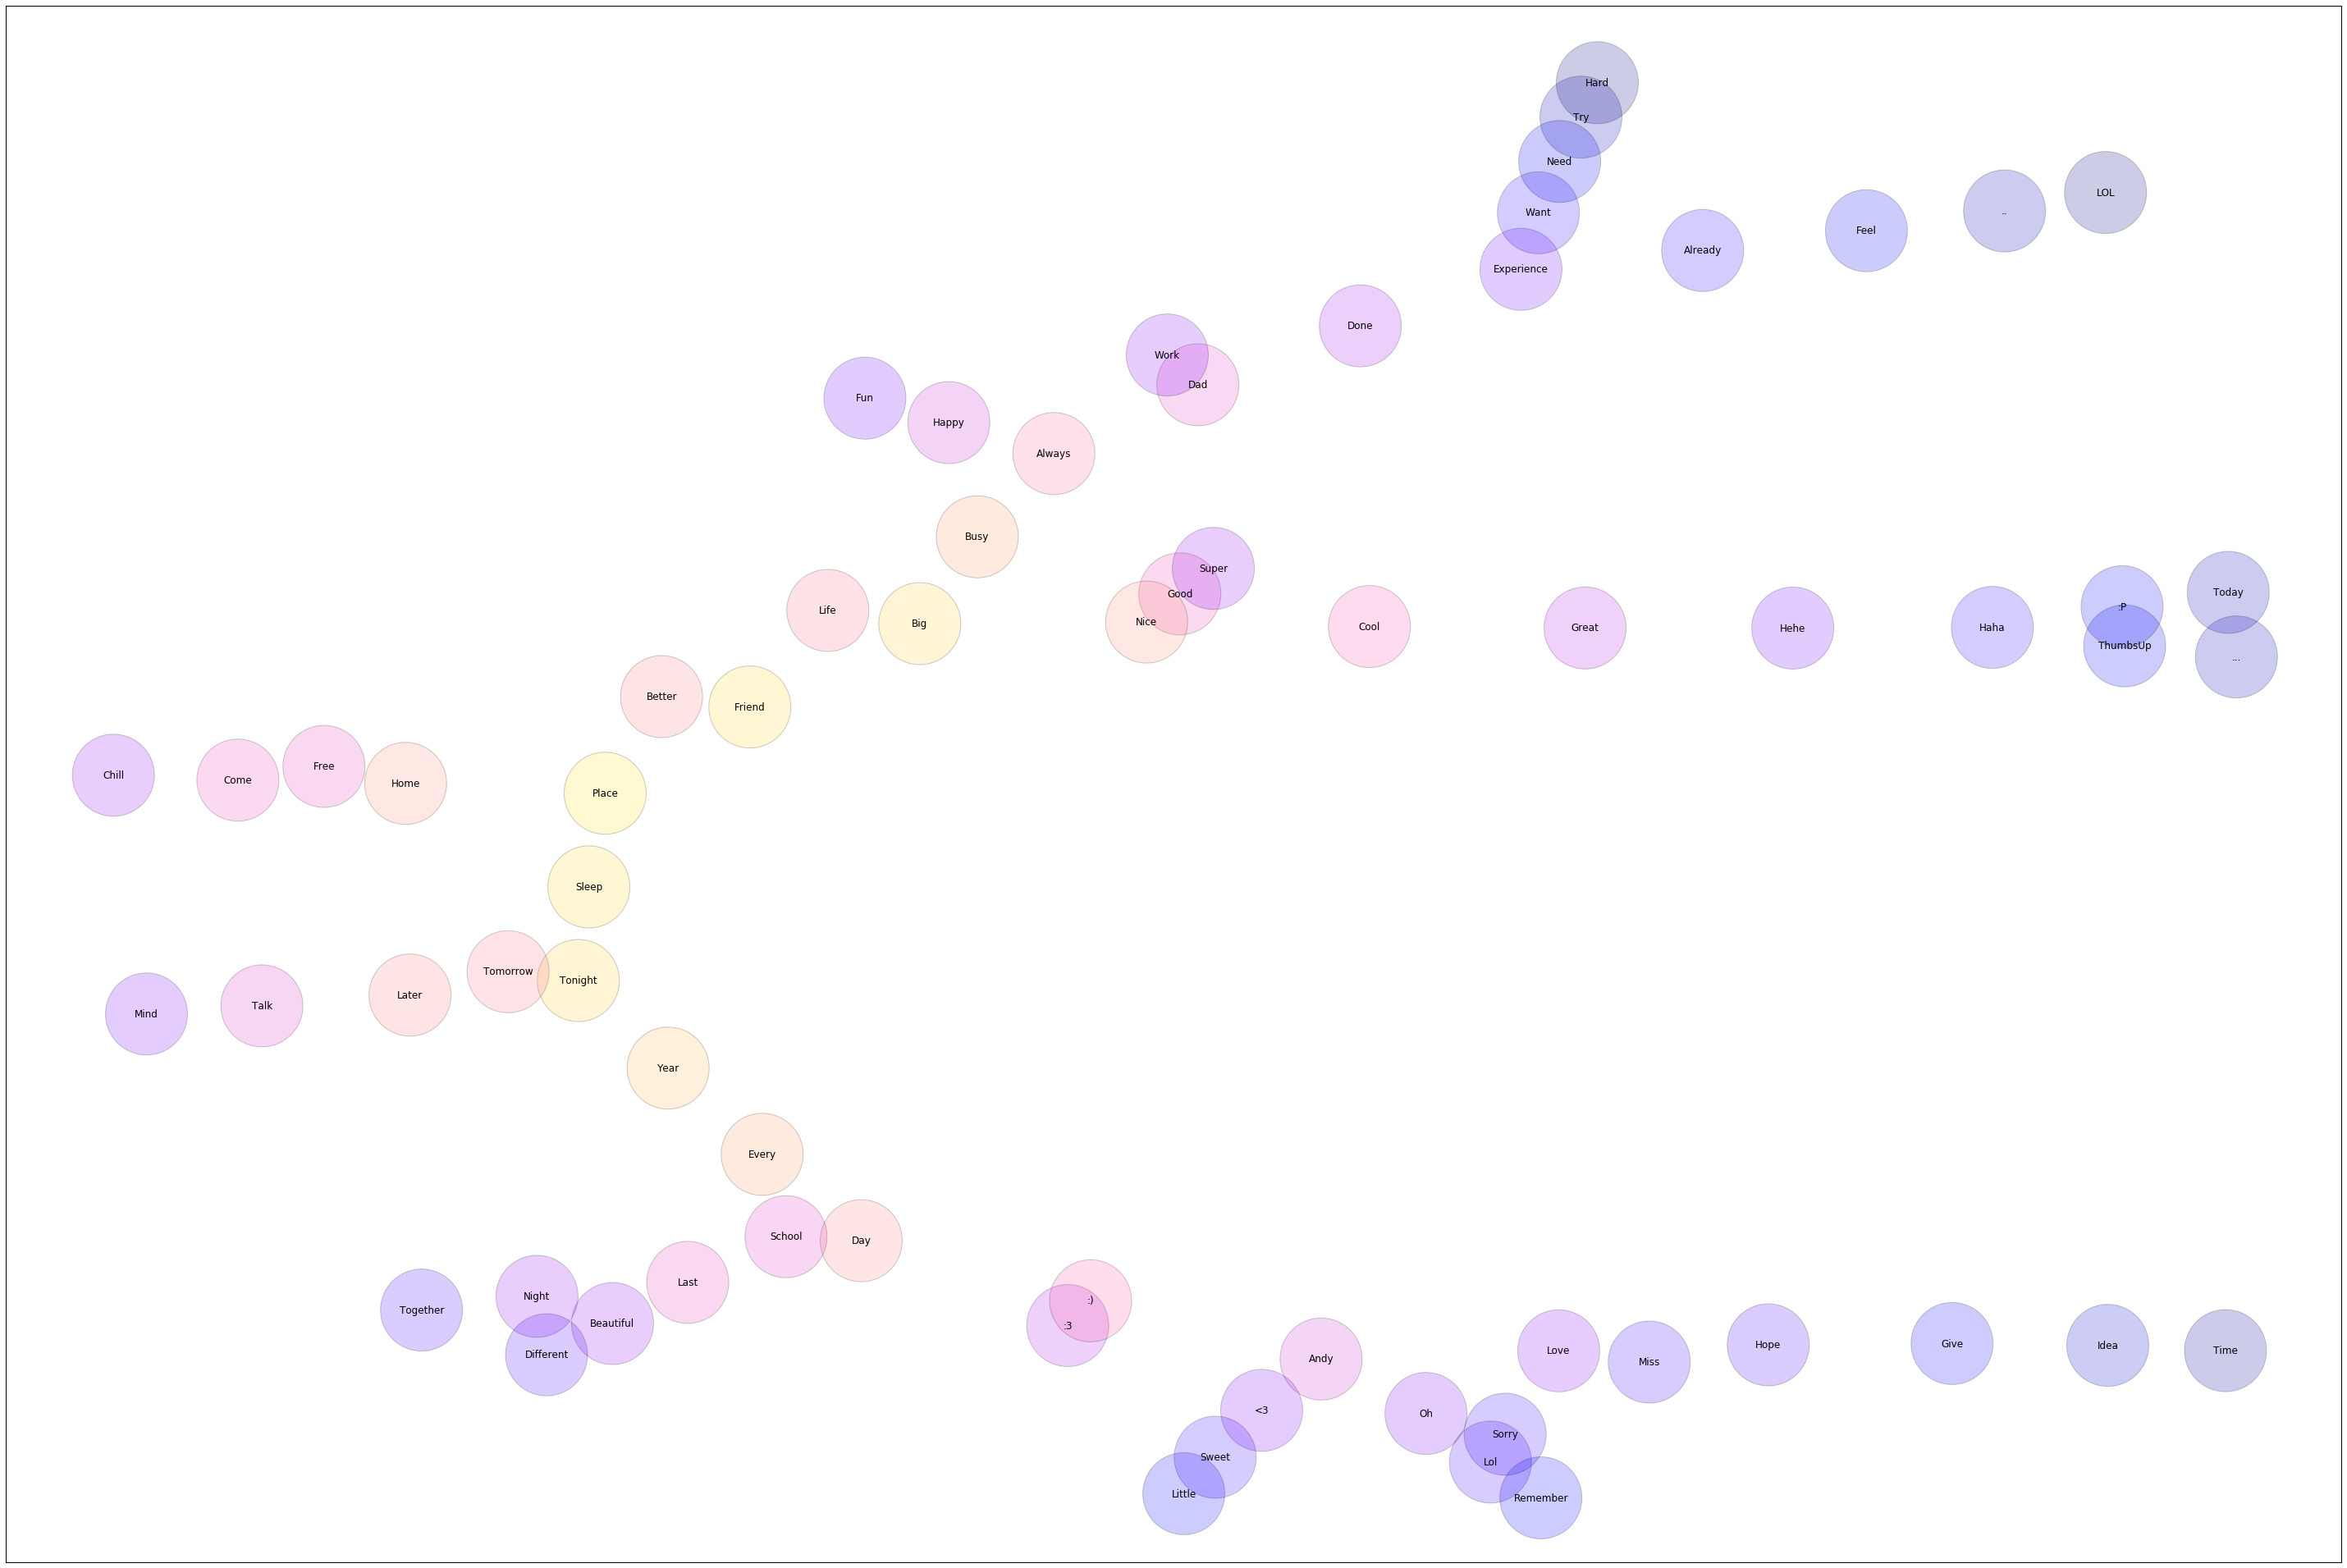

In [71]:
# Build graph
G_M  = build_mind_map(model = model_M,  root = top_terms_M[0], nodes = top_terms_M, alpha=0.2)

plot(G_M)

In [ ]:
# Repeat for both at the same time
all_sentences = all_sentences_M
all_sentences.extend(all_sentences_A)
shuffle(all_sentences)

model = Word2Vec(all_sentences, 
                   min_count = min_count, 
                   workers = workers, 
                   window = window, 
                   iter = iter, 
                   size = size)

In [186]:
vocab = list(model.vocab.keys())
print str(len(vocab)) + " words in the vocabulary"
print ""

# Find counts
full_word= []
for sentence in all_sentences:
    full_word.extend(sentence)
    
full_vocab_count= Counter(full_word)

sentence_vocab_count_list = []
for sentence in all_sentences:
    sentence_vocab_count_list.append(Counter(sentence)) 

# Determine top terms, slightly extending to 300 words
top_terms = get_top_n_terms(full_vocab_count, sentence_vocab_count_list, n = 325)
top_terms = [word for word in top_terms if word in vocab and word not in stop_list]

# Build graph
G  = build_mind_map(model = model,  root = top_terms[0], nodes = top_terms, alpha=0.0)
G_higher_alpha  = build_mind_map(model = model,  root = top_terms[0], nodes = top_terms, alpha=0.2)

1214 words in the vocabulary



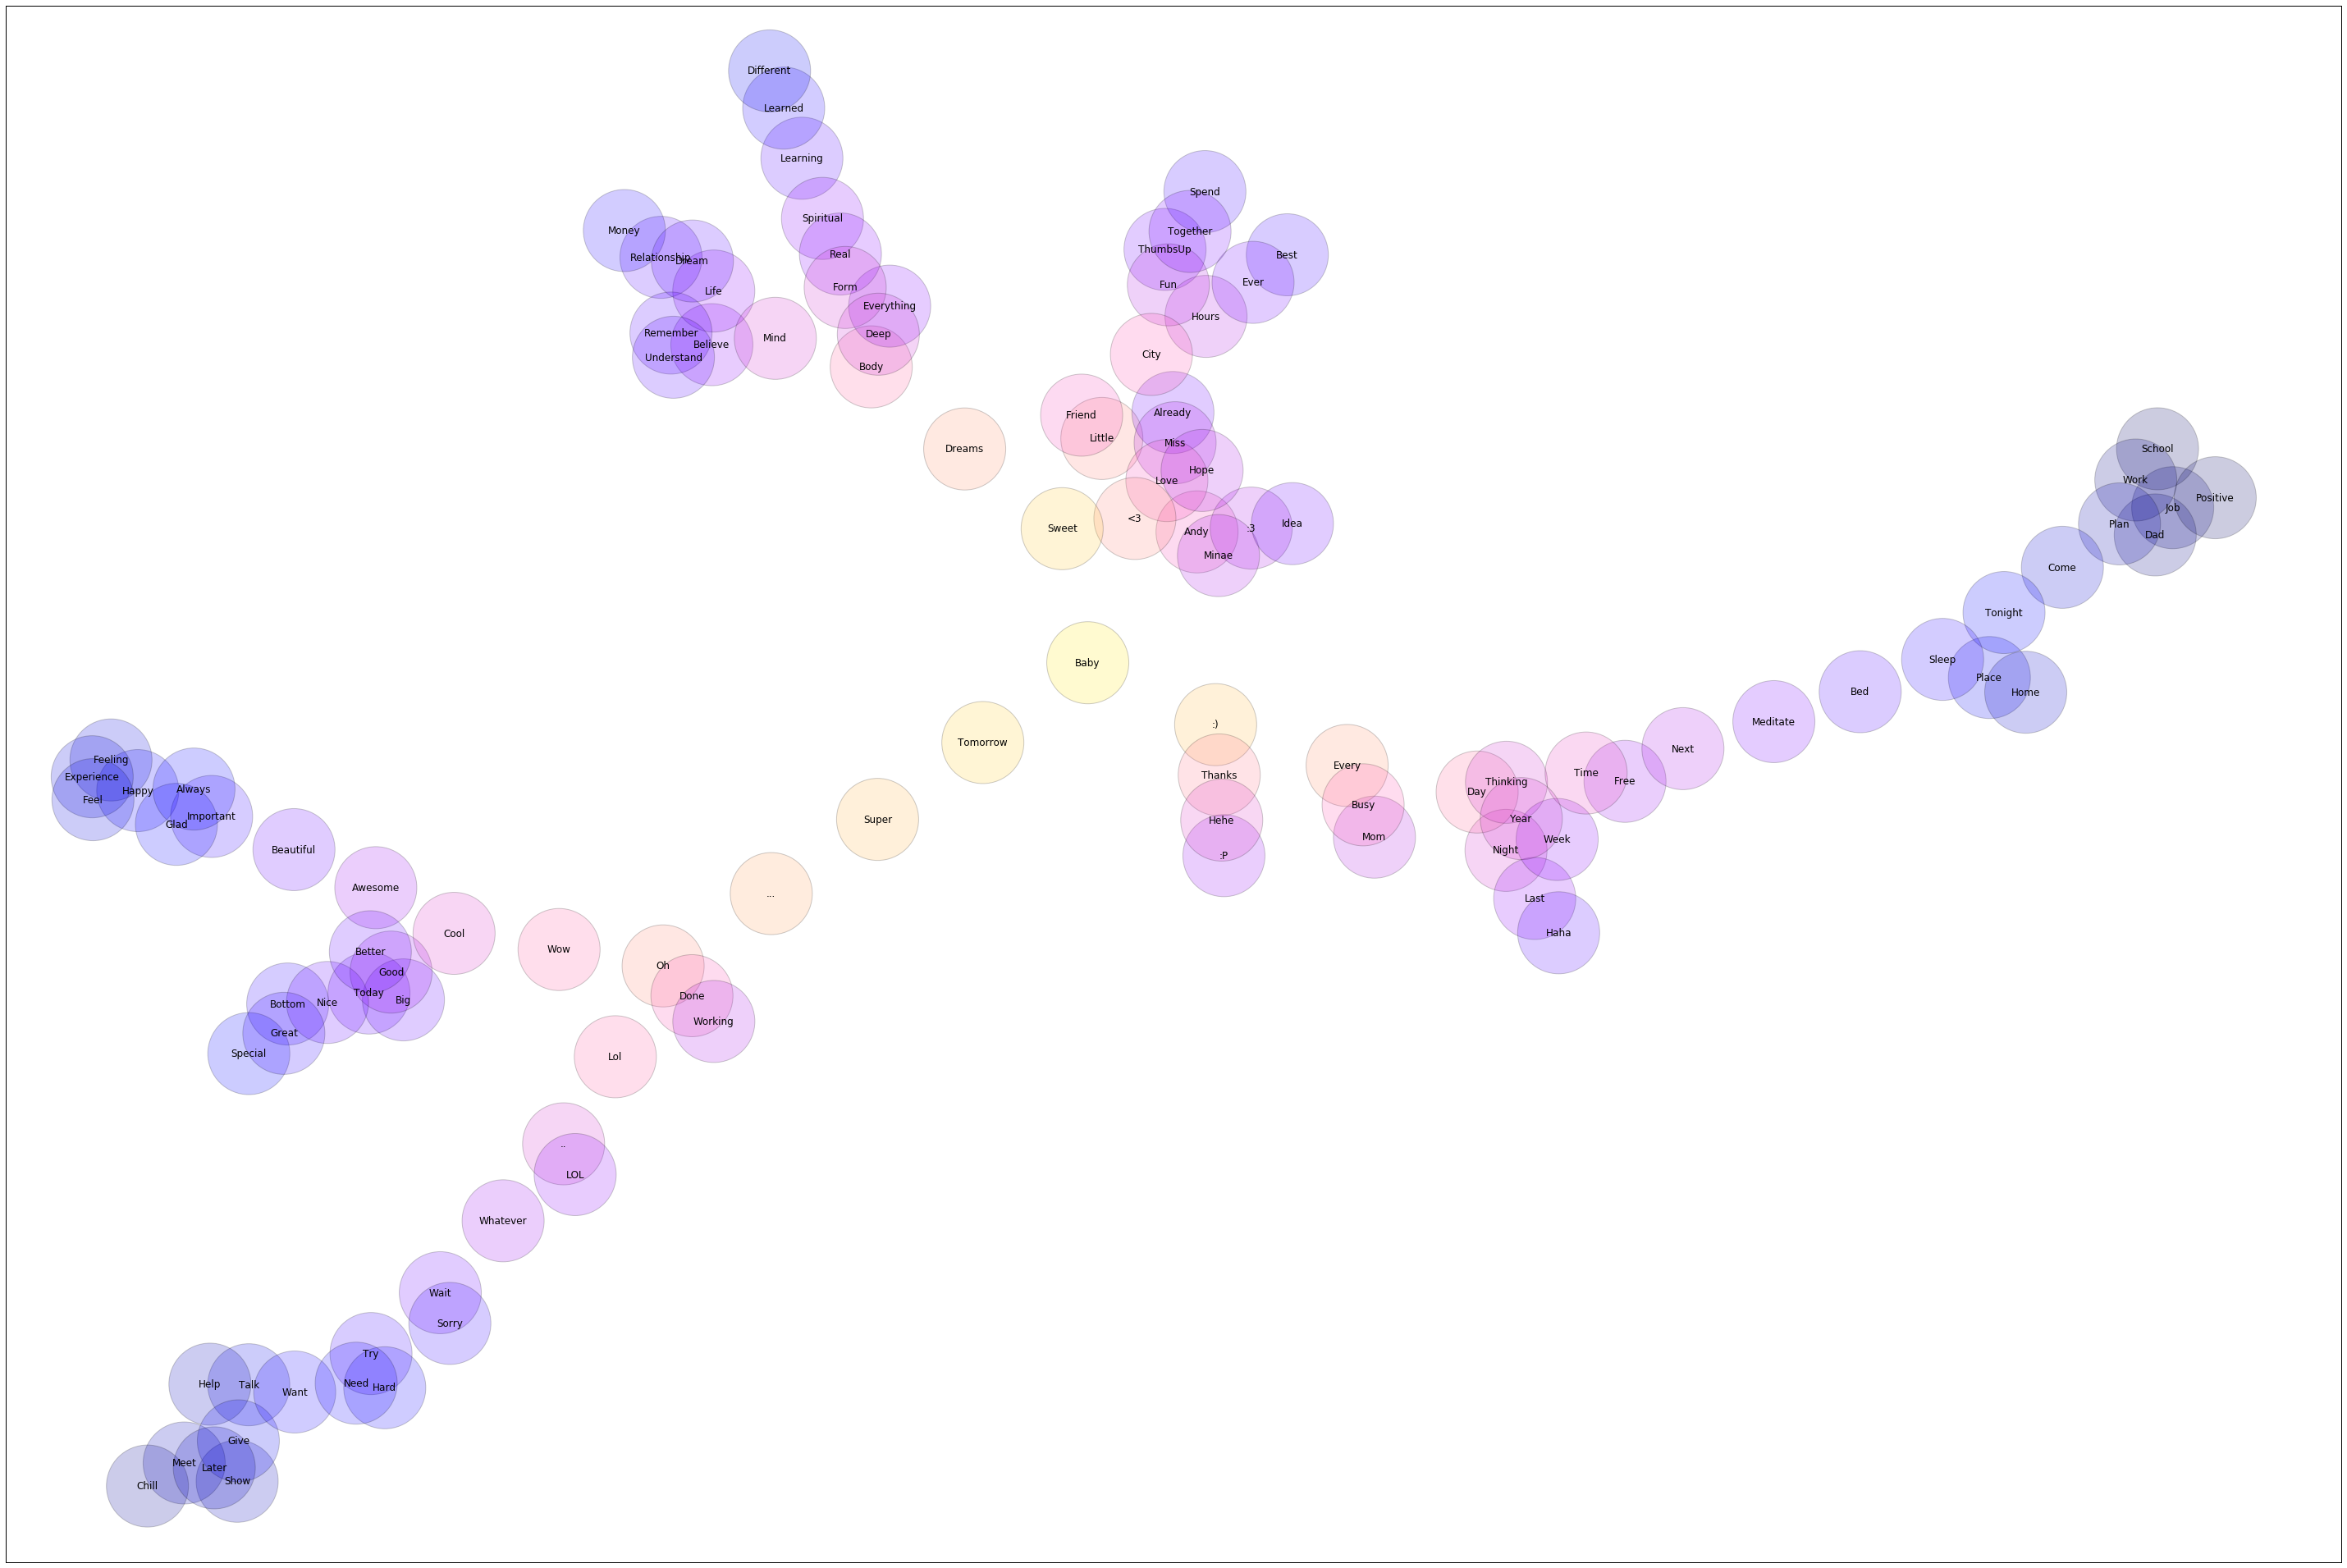

In [191]:
plot(G)

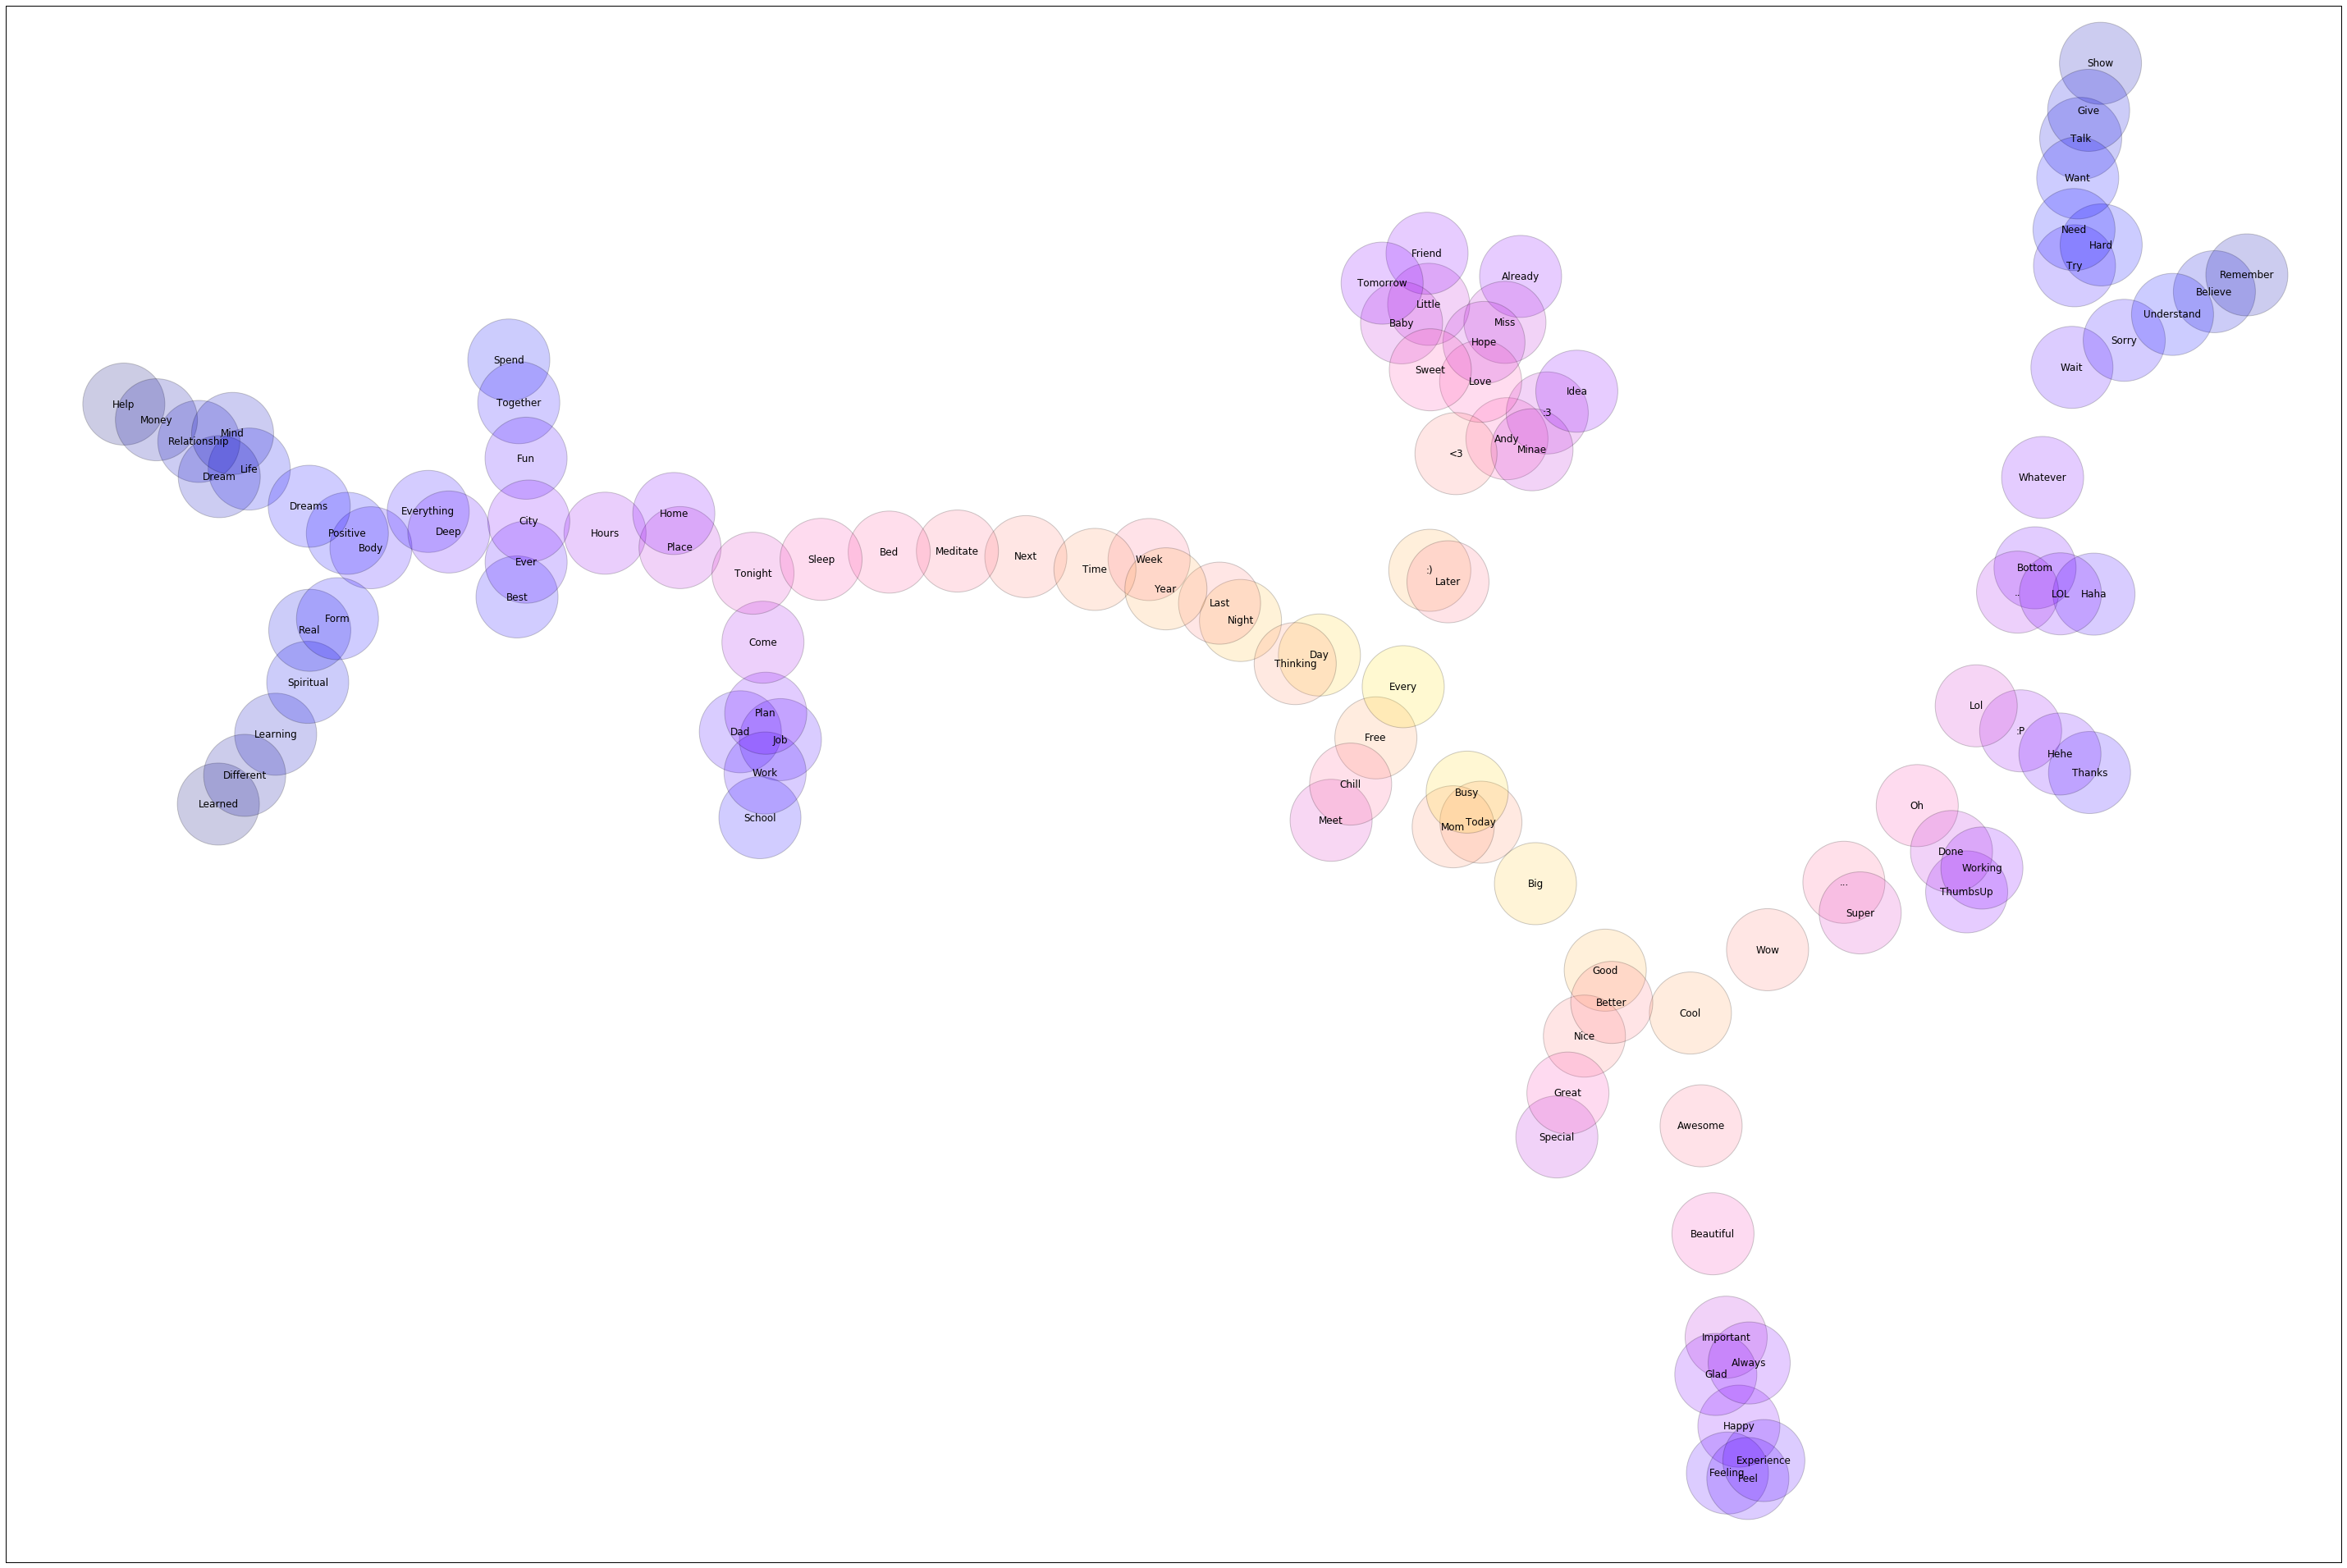

In [190]:
plot(G_higher_alpha)